In [324]:
from functions import *

In [325]:
# T = 0.01
# gamma = 0.2


# H_ising = np.diag(m.E_rescaled)
# H_mixer = H_mixer_list[m.n-1]
# H = (1-gamma)*H_ising + gamma*H_mixer
   
# d = len(H)
# n = int(np.log2(d))
# mag_basis = np.zeros(d)
# for i in range(d):
#     s = int_to_bin(i, n)
#     mag_basis[i] = (s.count('0') - s.count('1')) / n
# E, vecs = la.eigh(H)
# if T == 0:
#     boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
# else:
#     boltzmann_factors = scipy.special.softmax(-E / T)

# mag = 0
# for i, vec in enumerate(vecs.T):
#     mag += mag_basis @ vec**2 * boltzmann_factors[i]
# # mag = sum(np.dot(mag_basis, vecs * boltzmann_factors))

In [326]:
def magnetization(H, T):
    d = len(H)
    n = int(np.log2(d))
    mag_basis = np.zeros(d)
    for i in range(d):
        s = int_to_bin(i, n)
        mag_basis[i] = (s.count('0') - s.count('1')) / n
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)
    mag = 0
    for i, vec in enumerate(vecs.T):
        mag += mag_basis @ vec**2 * boltzmann_factors[i]
    return mag

In [327]:
n = 5
num_random_models = 10

gamma_lims = (0,1) 
gamma_steps = 30
T_lims = (1e-2,1e2)
T_steps = 30

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
T_range = np.geomspace(T_lims[0], T_lims[1], T_steps)

In [ ]:
# J_ferr = np.triu(np.ones(n),k=1) + np.triu(np.ones(n),k=1).T
# m = IsingModel(J_ferr, h=np.ones(n))

In [334]:
def f(T):
    mag = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n, local_fields=True)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            mag[gamma_id, i] = magnetization(H, T)
    return mag

In [335]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f)(t) for t in tqdm(T_range)))
mag = np.abs(sweep_data)
mag_avg = np.mean(mag, axis=2)
mag_std = np.std(mag, axis=2)

100%|██████████| 30/30 [00:02<00:00, 12.19it/s]


In [338]:
T_range

array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89390092e-02, 6.72335754e-02, 9.23670857e-02,
       1.26896100e-01, 1.74332882e-01, 2.39502662e-01, 3.29034456e-01,
       4.52035366e-01, 6.21016942e-01, 8.53167852e-01, 1.17210230e+00,
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02])

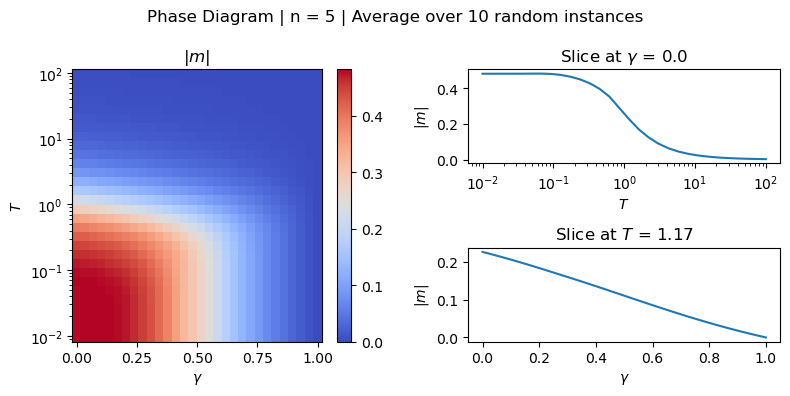

In [341]:
fig, axs = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(8, 4),
                              width_ratios=[2,2])
fig.suptitle(f'Phase Diagram | n = {n} | Average over {num_random_models} random instances')

pc = axs['left'].pcolor(gamma_range, 
                        T_range, 
                        mag_avg,
                        cmap='coolwarm')
fig.colorbar(pc, ax=axs['left'])
axs['left'].set_xlabel('$\gamma$')
axs['left'].set_ylabel('$T$')
axs['left'].set_yscale('log')
axs['left'].set_title('$|m|$')

axs['upper right'].plot(T_range, mag_avg[:,0])
axs['upper right'].set_xlabel('$T$')
axs['upper right'].set_xscale('log')
axs['upper right'].set_ylabel('$|m|$')
axs['upper right'].set_title(f'Slice at $\gamma$ = {gamma_range[0]}')

axs['lower right'].plot(gamma_range, mag_avg[15,:])
axs['lower right'].set_xlabel('$\gamma$')
axs['lower right'].set_ylabel('$|m|$')
axs['lower right'].set_title(f'Slice at $T$ = {T_range[15].round(2)}')

fig.tight_layout()